In [1]:
from unhippo.models.lds import HiPPOSystem, UnHiPPOSystem
from numpy.polynomial import Legendre
from numpy.polynomial.legendre import legvander

In [2]:
n = 128

def f(t):
    #return torch.where(t > 7, 7, t **2 - 3 * t + 3)
    return torch.sin(torch.pi * t) * torch.exp(-torch.sin(t))
rng = np.random.default_rng(1337)
#f = Legendre(rng.normal(size=n), domain=(0, 10))
torch.random.manual_seed(1337)
n_data = 500
t = ((1 + torch.arange(n_data)) / n_data) * 10
data_true_ = f(t)
noise = torch.randn(size=(len(t),))
#sigma_t = (torch.sin(3 * t + 1.5) + 1) / 2
data_true = data_true_ + 0.1 * noise
#data_true = data_true[:25]

torch.Size([500, 128])
torch.Size([500])


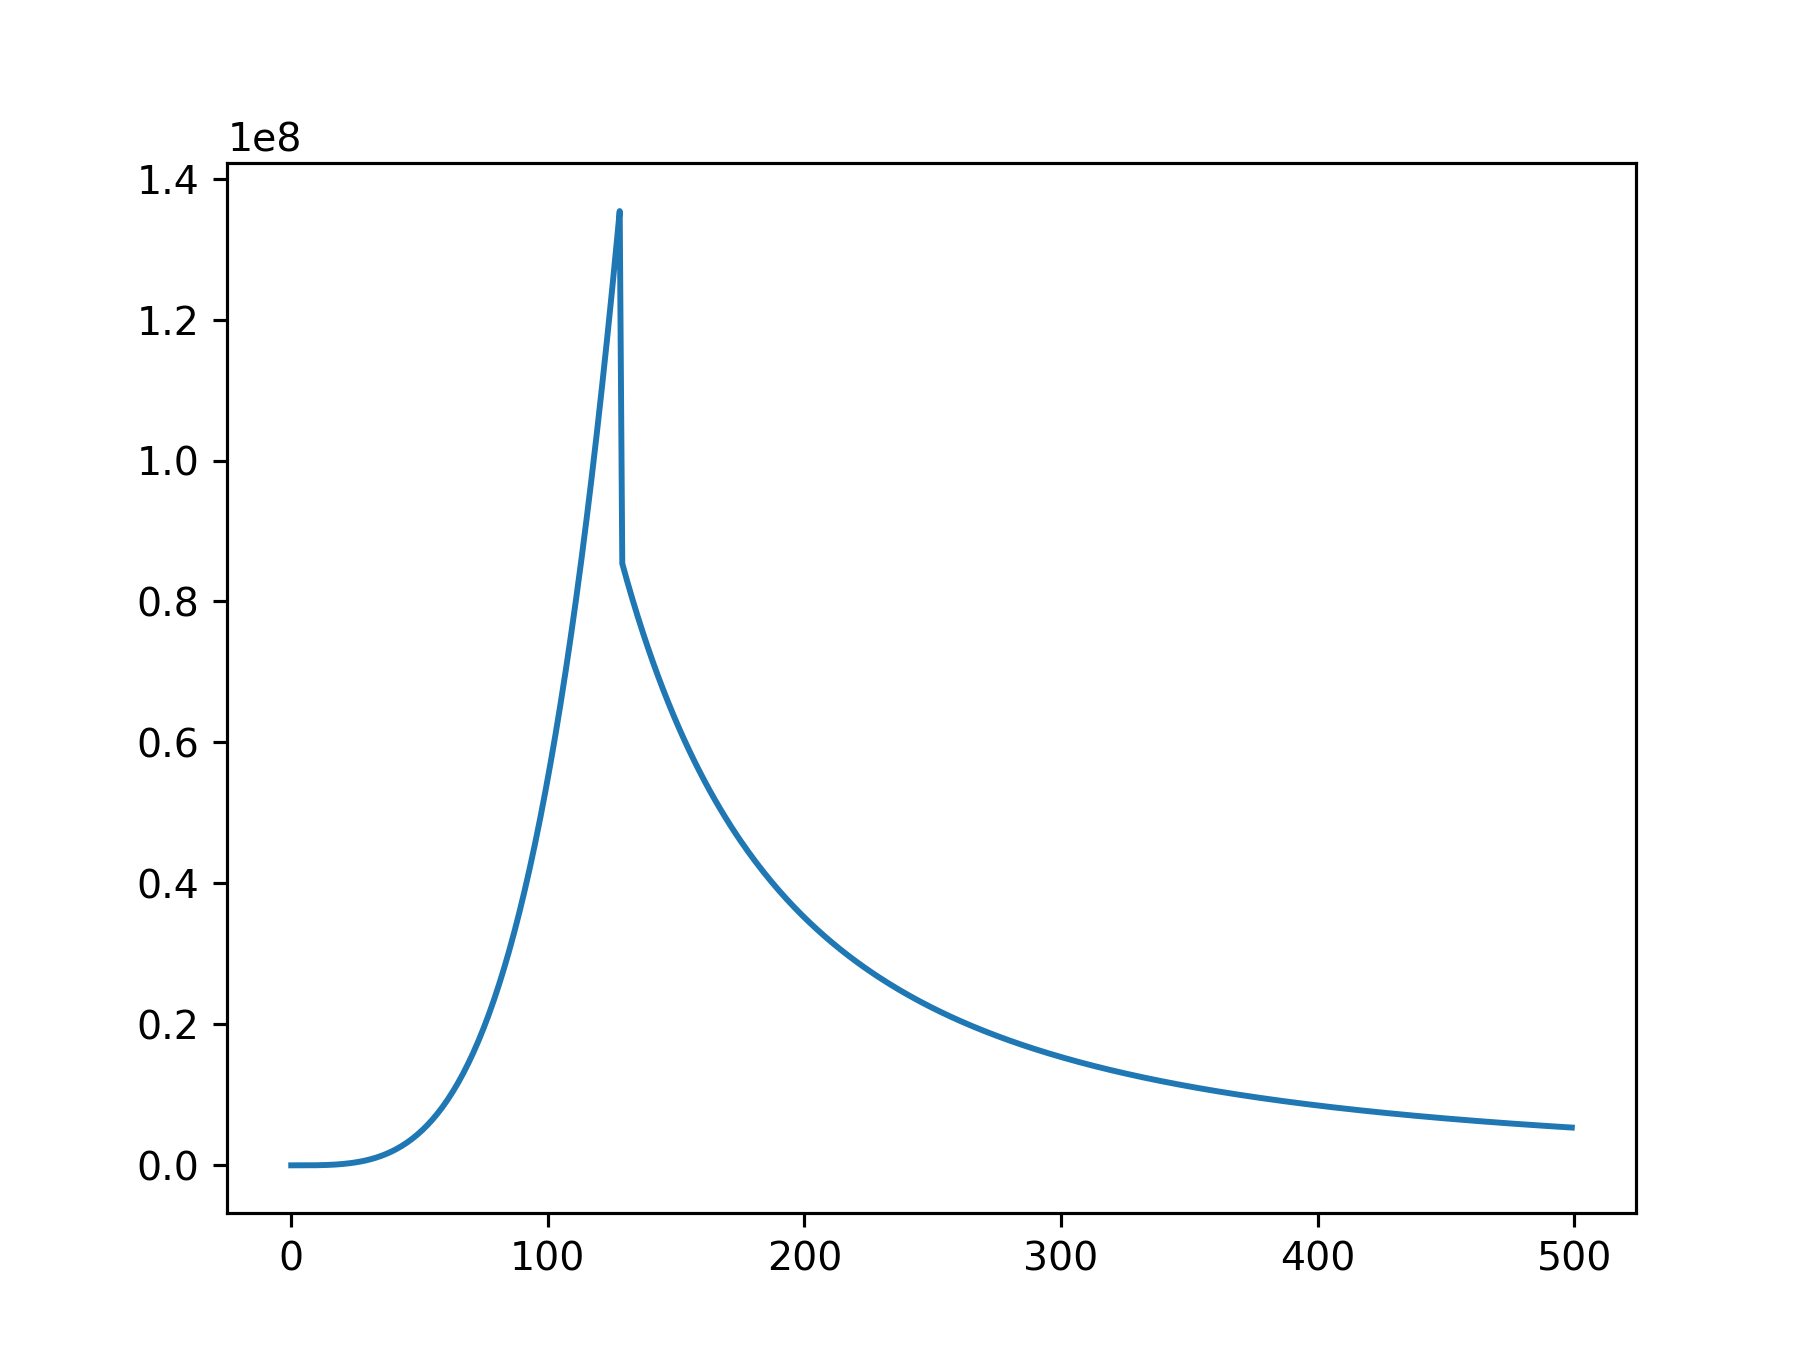

In [3]:
#hippo = HiPPOSystem(n, control_type="data").float()
#hippo = HiPPOSystem(n, control_type="auto").float()
# sigma_weight = ("sigmoid", 1, 0.1)
sigma_weight = ("lopsided", 1, 0.1, 10)
# sigma_weight = None
hippo = UnHiPPOSystem(
    n, rho=0.25, discretization_method="bilinear",
    regularize_derivative=True,
    covariance_type="qr",
    sigma=1.0,
    sigma_weight=sigma_weight).float()
c_roll_out = hippo.roll_out(K=len(data_true), control_signal_kwargs={"data": data_true})
c_filter, _, extra_filter = hippo.kalman_filter(data_true, control_signal_kwargs={"data": data_true}, log_intermediates=True)
P_filter = extra_filter.P_k
print(c_roll_out.shape)
print(data_true.shape)
pp.plot(extra_filter.S_k)

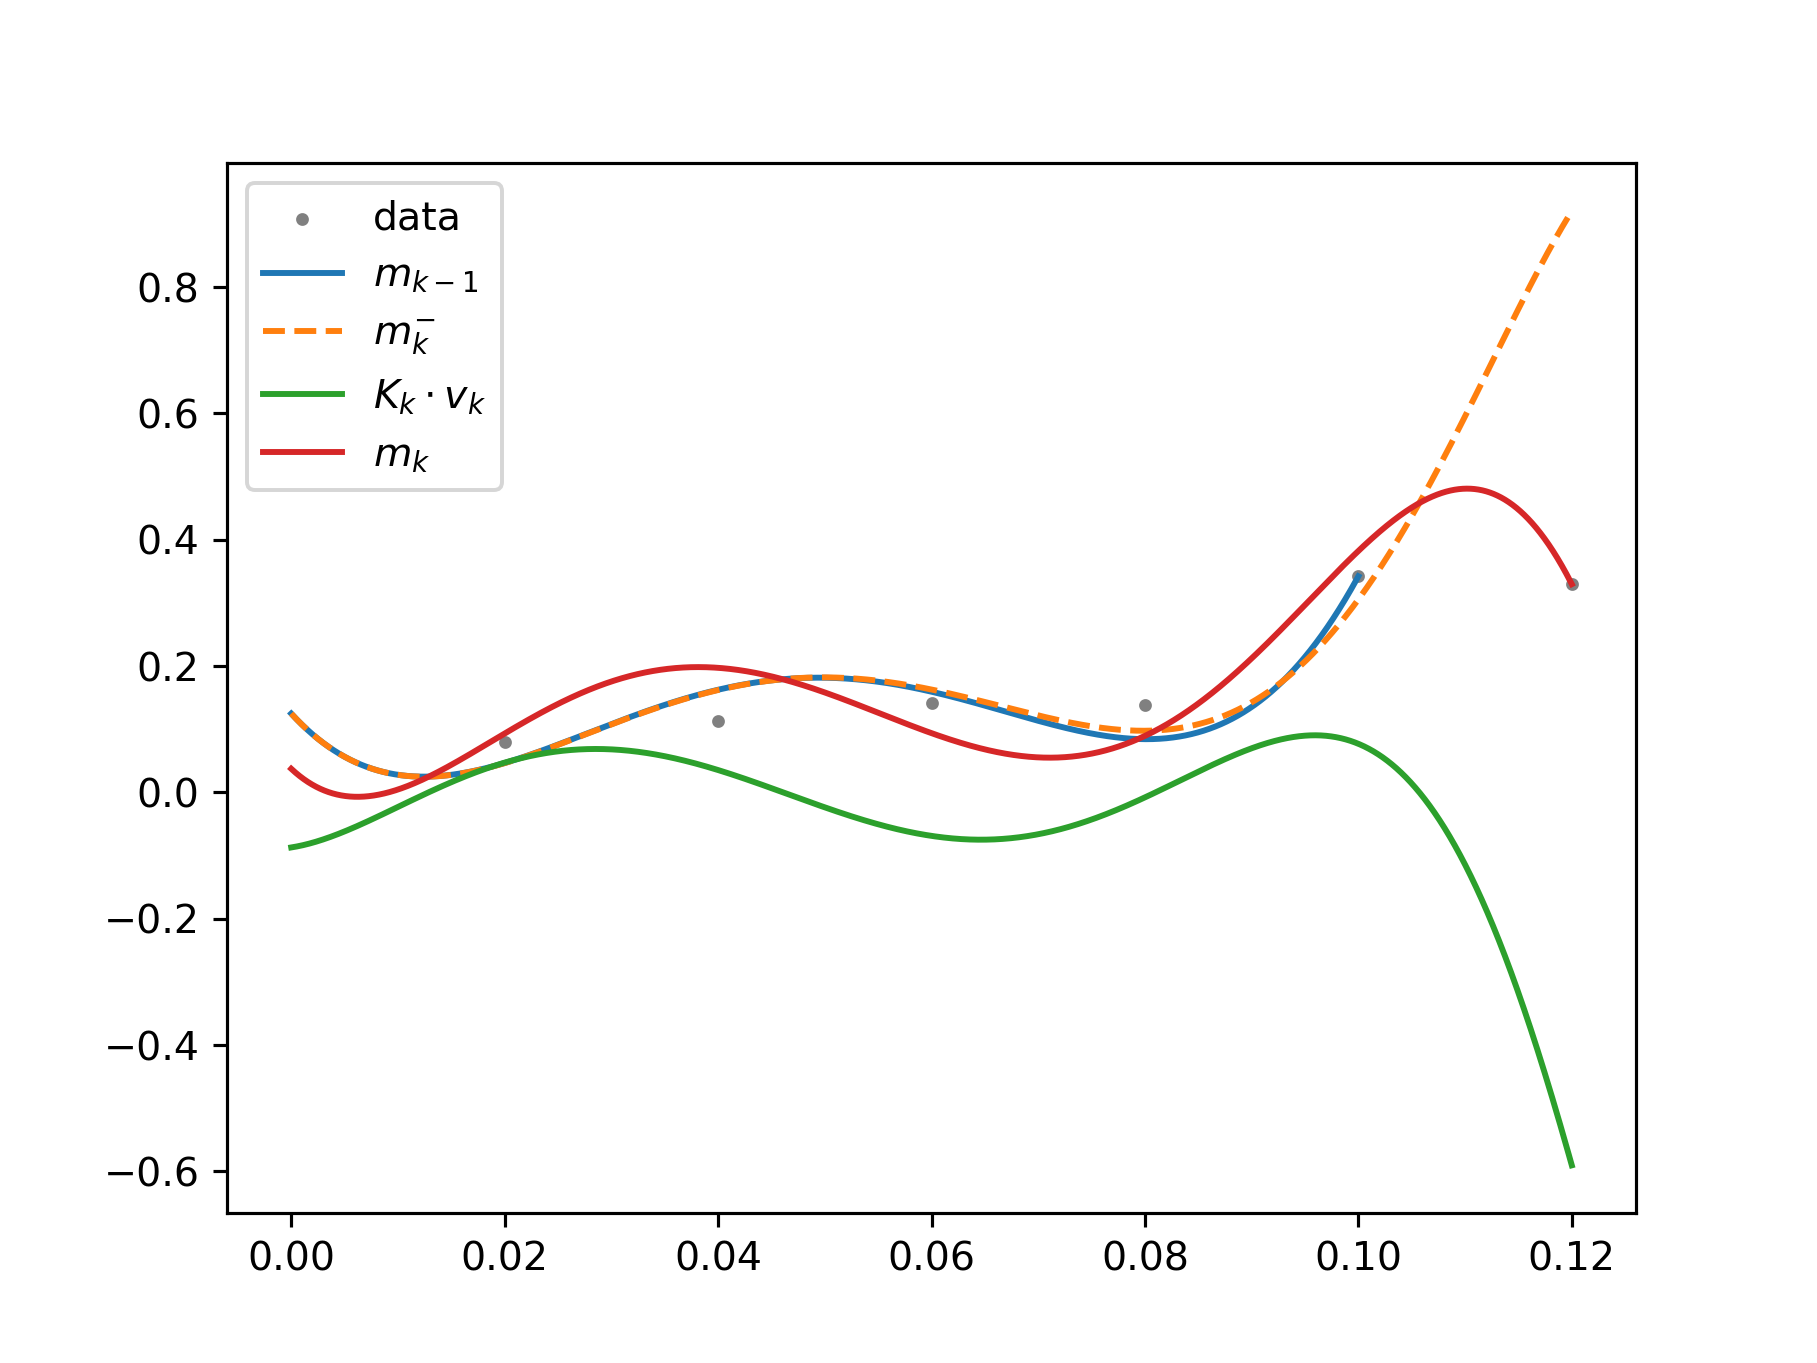

In [4]:
step = 5
t_step = t[:step + 1]
t_eval = np.linspace(0, t_step[-1], 10000)

pp.scatter(t_step, data_true[:step + 1], s=5, c="gray", label="data")

## 500 
## n = 128
# for each step get one step ahead prediction 
## 500 x 128
# 501st step

if step > 0:
    t_eval_prev = np.linspace(0, t_step[-2], 10000)
    pp.plot(t_eval_prev, hippo.reconstruct(extra_filter.m_k[step - 1], domain=(0, t_step[-2]))(t_eval_prev), label=r"$m_{k-1}$")
    #pp.plot(t_eval, hippo.reconstruct(extra_filter.m_k[step - 1], domain=(0, t_step[-2]))(t_eval), label=r"$m_{k-1}$ extrapolated")
pp.plot(t_eval, hippo.reconstruct(extra_filter.m_k_apriori[step], domain=(0, t_step[-1]))(t_eval), label=r"$m_{k}^{-}$", ls="--")
pp.plot(t_eval, hippo.reconstruct(extra_filter.K_k[step] * extra_filter.v_k[step], domain=(0, t_step[-1]))(t_eval), label=r"$K_{k} \cdot v_k$")
#pp.plot(t_eval, hippo.reconstruct(extra_filter.K_k[step, :, 0], domain=(0, t_step[-1]))(t_eval), label=r"$K_{k}$")
pp.plot(t_eval, hippo.reconstruct(extra_filter.m_k[step], domain=(0, t_step[-1]))(t_eval), label=r"$m_{k}$")

#pp.xlim((t_step[-1] - 0.1, t_step[-1] + 0.02))
#pp.ylim((-3, -1))
pp.legend()

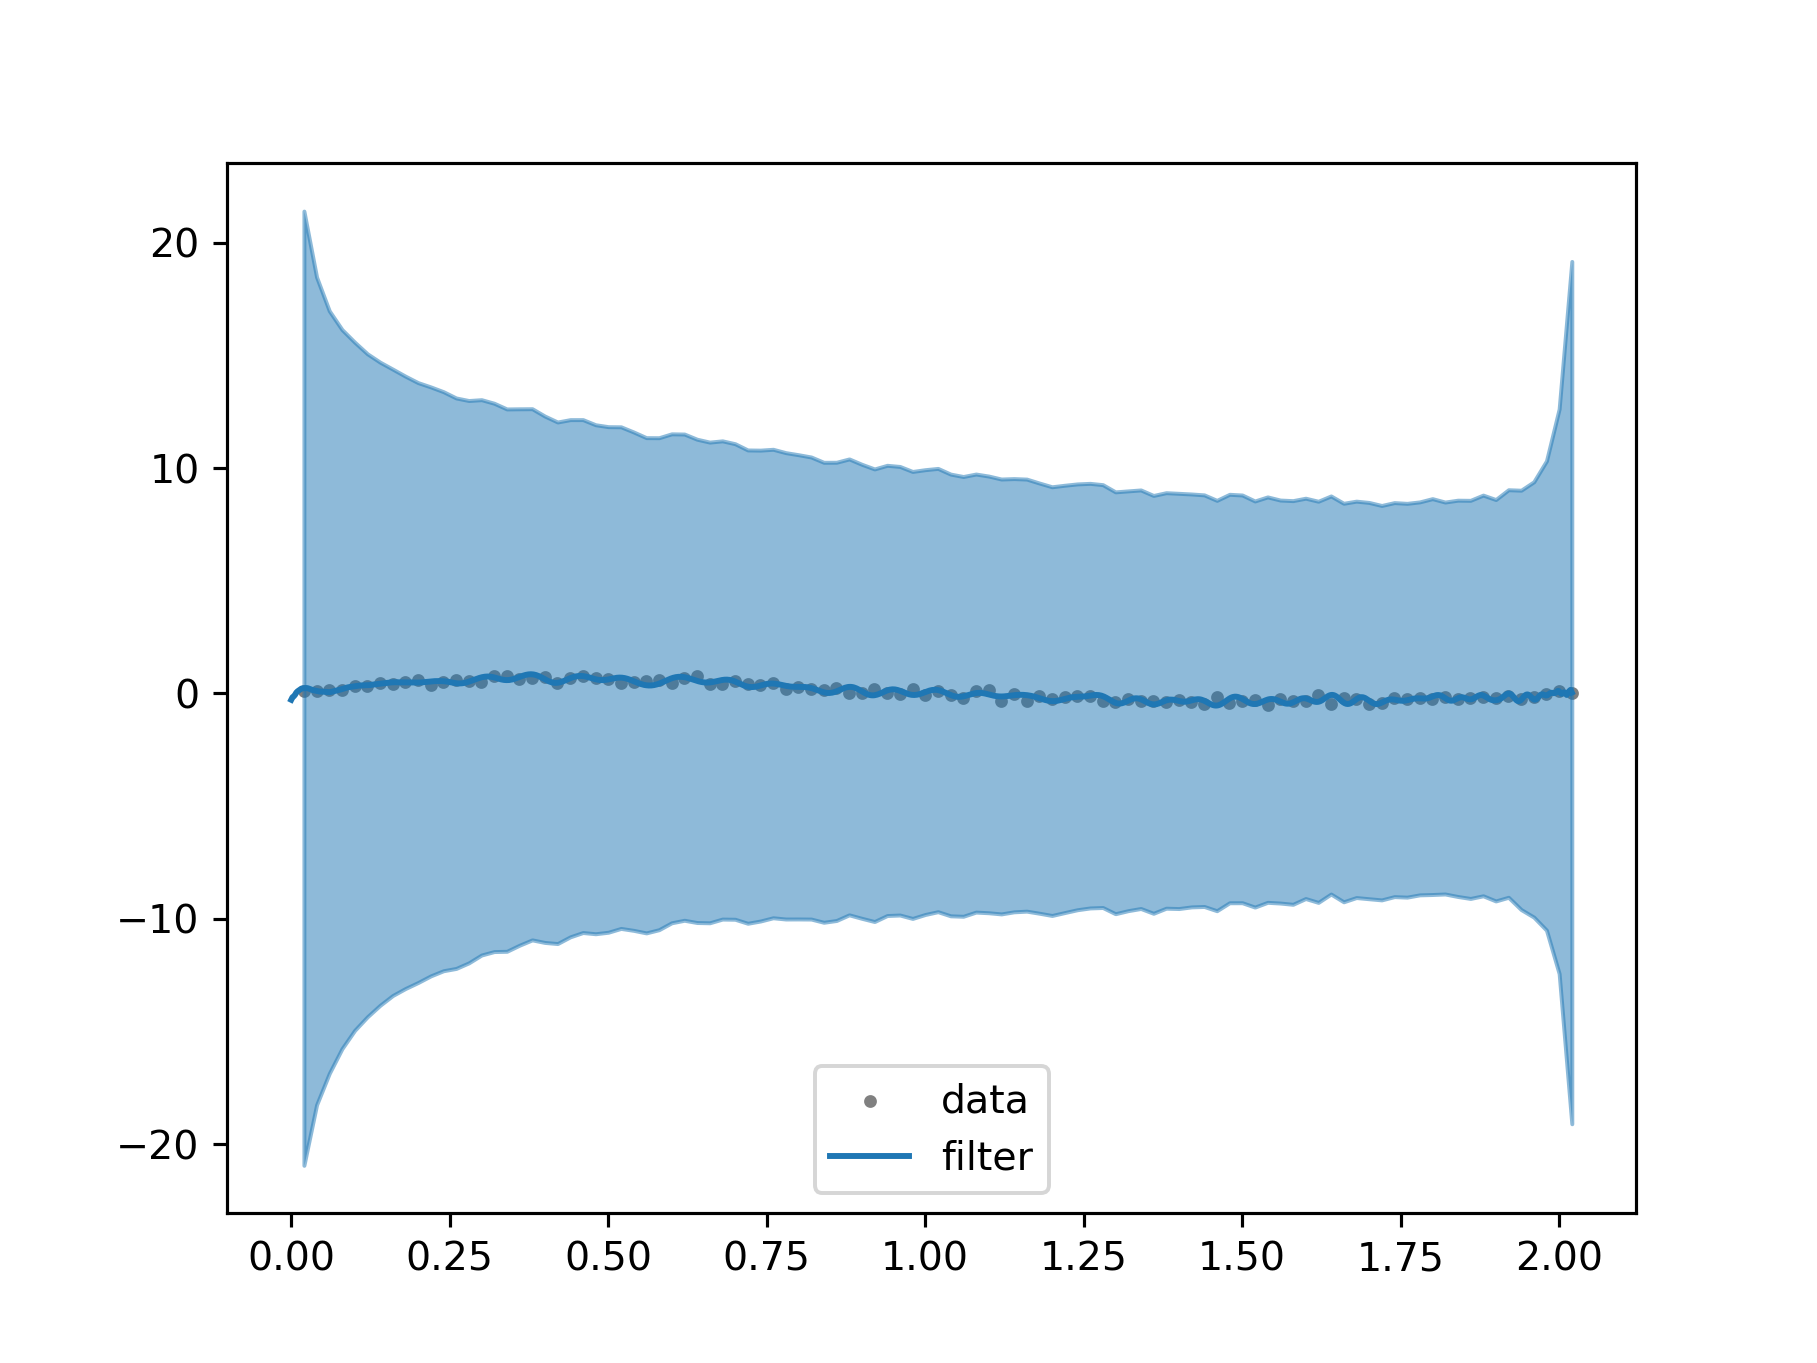

In [5]:
step = 100
t_step = t[:step + 1]
t_eval = np.linspace(0, t_step[-1], 1000)

pp.scatter(t_step, data_true[:step + 1], s=5, c="gray", label="data")

#poly_K = hippo.reconstruct(c_roll_out[step], domain=(0, t_step[-1]))
#pp.plot(t_eval, poly_K(t_eval), label="roll-out")

poly_K = hippo.reconstruct(c_filter[step], domain=(0, t_step[-1]))
line, = pp.plot(t_eval, poly_K(t_eval), label="filter")
mu = poly_K(t_step)
H = legvander((2 * t_step / t_step.max()) - 1, n - 1)
P_k = P_filter[step].numpy()
if hippo.covariance_type == "qr":
    P_k = P_k.T @ P_k
Sig = np.sqrt(np.diag((H @ P_k @ H.T)))
pp.fill_between(t_step, mu - Sig, mu + Sig, color=line.get_color(), alpha=0.5)

pp.legend()

In [6]:
for step in range(len(c_filter)):
    #P_k = extra_filter.P_k[step][:step + 1,:step + 1]
    P_k = extra_filter.P_k[step]
    if hippo.covariance_type == "qr":
        P_k = P_k.T @ P_k
    eigvals = torch.linalg.eigvals(P_k)
    assert all(eigvals.imag.abs() < 1e-10), (step, eigvals.imag.abs().max().item())
    min_eigval = eigvals.real.min().item()
    if min_eigval < 0.0:
        print(step, min_eigval)
        break

1 -4.11102428308064e-23
